In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib
from astropy.io.votable import parse_single_table
from scipy.stats import binned_statistic_2d

matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

# how to manually import code based on its path
import sys
sys.path.append('../ingot/')
from ingot import FeH

## All Sky
Look at the [Fe/H] we get from exploring 11 Million stars with Gaia + WISE data.

Note: we probaby need to update this to use the Bailer-Jones distances...

(and maybe `Ingot` itself)

In [2]:
# tbl = parse_single_table('/Users/james/Downloads/1528491826414O-result.vot').to_table()
# df = tbl.to_pandas() # b/c I love Pandas

In [3]:
df = pd.read_csv('/Users/james/Downloads/1528491826414O-result.csv')

In [4]:
df.columns

Index(['ra', 'dec', 'parallax', 'parallax_error', 'a_g_val', 'phot_g_mean_mag',
       'phot_g_mean_flux', 'phot_g_mean_flux_error', 'w1mpro', 'w1mpro_error',
       'w2mpro', 'w2mpro_error', 'j_m', 'j_msigcom'],
      dtype='object')

In [17]:
M_G = df['phot_g_mean_mag'] - 5. * np.log10(1000./df['parallax']) + 5.
feh, feherr = FeH(df['w1mpro']-df['w2mpro'], df['phot_g_mean_mag']-df['j_m'], M_G, use_MG=True)

## Make Color-Mag and Color-Color figures again

In [62]:
print(np.shape(df))
best = np.where((df['phot_g_mean_mag']-df['j_m'] > 0.5) & 
                (df['phot_g_mean_mag']-df['j_m'] < 3) & 
                (df['w1mpro']-df['w2mpro'] > -0.13) & 
                (df['w1mpro']-df['w2mpro'] < 0.2) & 
                (M_G < 11.5) & 
                (df['w1mpro_error'] < 0.03) & 
                (df['j_msigcom'] < 0.03) & 
                (df['parallax_error'] / df['parallax'] < 0.02))[0]# & 
#                 (df['a_g_val'] < 0.1))[0]

print(np.shape(best))

(11720159, 14)
(3880305,)


Text(0,0.5,'$G-J$ (mag)')

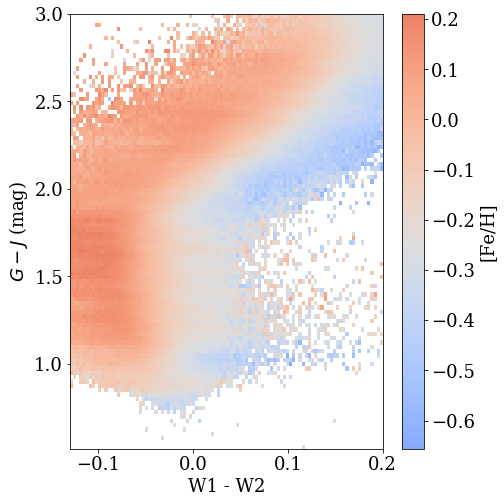

In [63]:
stat0, xe0, ye0, bn0 = binned_statistic_2d(df['w1mpro'].values[best]-df['w2mpro'].values[best], 
                                           df['phot_g_mean_mag'].values[best]-df['j_m'].values[best], 
                                           feh[best], statistic='mean', bins=100)

plt.figure(figsize=(7,8))
# plt.scatter(df['w1mpro']-df['w2mpro'],
#             df['phot_g_mean_mag']-df['j_m'],
#             s=1, alpha=0.75, c=feh, cmap=plt.cm.coolwarm)
plt.imshow(stat0.T, origin='lower', interpolation='nearest',aspect='auto',
           extent=[xe0.min(), xe0.max(), ye0.min(), ye0.max()], cmap=plt.cm.coolwarm)


cb = plt.colorbar()
cb.set_label('[Fe/H]')
cb.set_clim(-1,0.5)
# plt.xlim(-0.2,0.3)
# plt.ylim(0.7, 3.1)
plt.xlabel('W1 - W2')
plt.ylabel('$G-J$ (mag)')

Text(0,0.5,'$M_G$ (mag)')

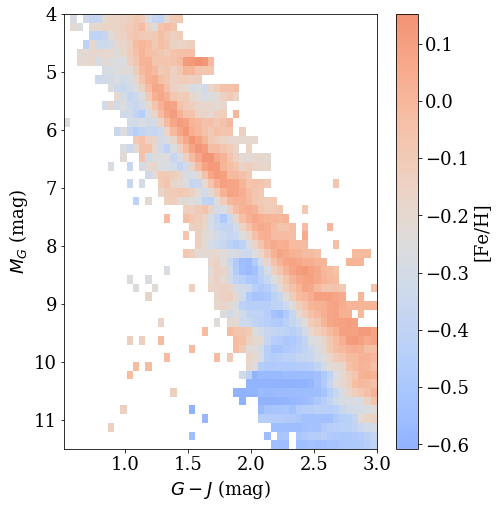

In [64]:
stat0, xe0, ye0, bn0 = binned_statistic_2d(df['phot_g_mean_mag'].values[best]-df['j_m'].values[best], 
                                           M_G[best], feh[best], statistic='mean', bins=50)

plt.figure(figsize=(7,8))
plt.imshow(stat0.T, origin='lower', interpolation='nearest', aspect='auto', 
           extent=[xe0.min(), xe0.max(), ye0.min(), ye0.max()], cmap=plt.cm.coolwarm)

cb = plt.colorbar()
cb.set_label('[Fe/H]')
cb.set_clim(-1,0.5)
# plt.xlim(0.7, 3.1)
# plt.ylim(12,3)
plt.gca().invert_yaxis()
plt.xlabel('$G-J$ (mag)')
plt.ylabel('$M_G$ (mag)')

## Make RA, Dec and (R,Z) maps of average [Fe/H]

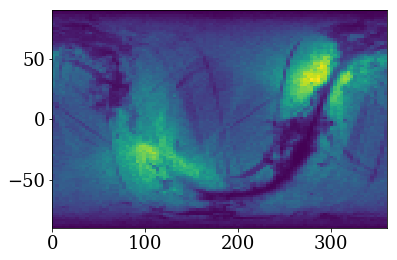

In [65]:
_ = plt.hist2d(df['ra'].values[best], df['dec'].values[best], bins=100)

In [66]:
stat, xe, ye, bn = binned_statistic_2d(df['ra'].values[best], df['dec'].values[best], 
                                       feh[best], statistic='mean', bins=100)

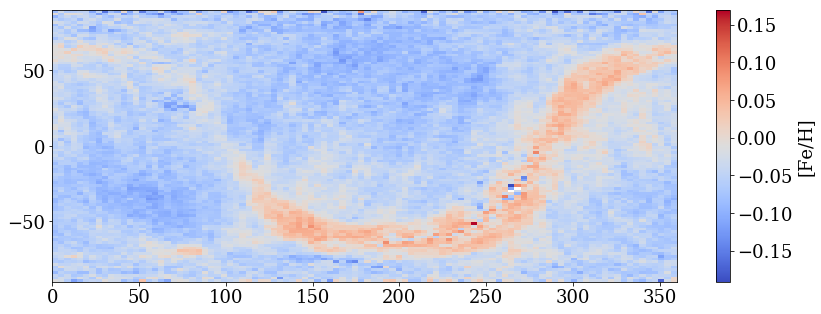

In [67]:
plt.figure(figsize=(14,5))
plt.imshow(stat.T, origin='lower', interpolation='nearest', aspect='auto', 
           extent=[xe.min(), xe.max(), ye.min(), ye.max()], cmap=plt.cm.coolwarm)
cb = plt.colorbar()
cb.set_label('[Fe/H]')

In [68]:
# convert (ra,dec,dist) into (X,Y,Z)
# http://docs.astropy.org/en/stable/api/astropy.coordinates.Galactocentric.html
import astropy.units as u
import astropy.coordinates as coord
c = coord.ICRS(ra=df['ra'].values * u.degree,
               dec=df['dec'].values * u.degree,
               distance=1000./df['parallax'].values * u.pc)
galC = c.transform_to(coord.Galactocentric)

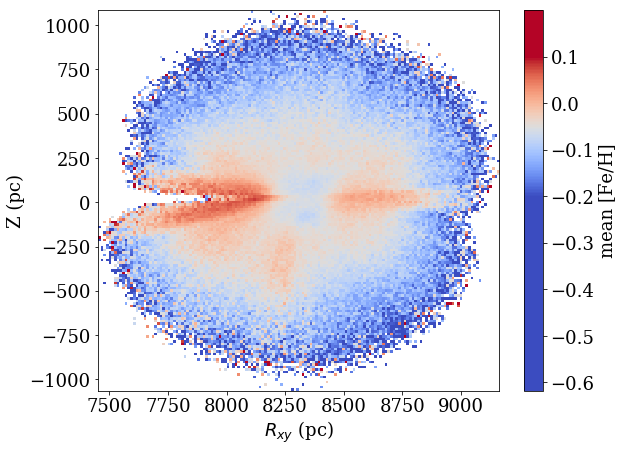

In [69]:
stat2, xe2, ye2, bn2 = binned_statistic_2d(np.sqrt(galC.x.value[best]**2 + galC.y.value[best]**2), 
                                           galC.z.value[best],
                                           feh[best], statistic='mean', bins=150)

plt.figure(figsize=(9,7))
plt.imshow(stat2.T, origin='lower', interpolation='nearest', aspect='auto', 
           extent=[xe2.min(), xe2.max(), ye2.min(), ye2.max()], cmap=plt.cm.coolwarm)
plt.xlabel('$R_{xy}$ (pc)')
plt.ylabel('Z (pc)')
cb = plt.colorbar()
cb.set_label('mean [Fe/H]')
cb.set_clim(-0.2,0.1)

(-500, 500)

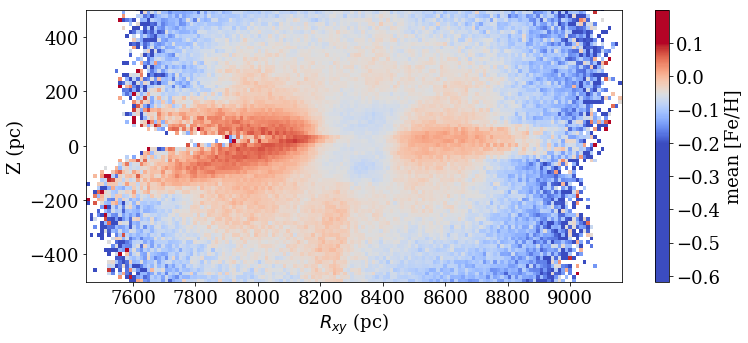

In [70]:
plt.figure(figsize=(12,5))
plt.imshow(stat2.T, origin='lower', interpolation='nearest', aspect='auto', 
           extent=[xe2.min(), xe2.max(), ye2.min(), ye2.max()], cmap=plt.cm.coolwarm)
plt.xlabel('$R_{xy}$ (pc)')
plt.ylabel('Z (pc)')
cb = plt.colorbar()
cb.set_label('mean [Fe/H]')
cb.set_clim(-0.2,0.1)
plt.ylim(-500,500)

Text(0,0.5,'|Z| (kpc)')

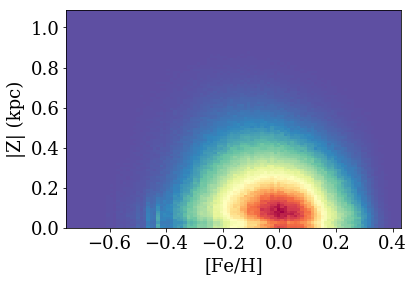

In [71]:
# Figure 5 from Ivezic+2008

# plt.figure(figsize=(14,5))
_ = plt.hist2d(feh[best], np.abs(galC.z.value[best])/1e3, bins=100, 
               normed=LogNorm, cmap=plt.cm.Spectral_r)
plt.xlabel('[Fe/H]')
plt.ylabel('|Z| (kpc)')


# DUST
we need to control for it

also, we're off the rails here in terms of parameter space in the color-color diagram we use to estimate [Fe/H]

In [58]:
# stat2, xe2, ye2, bn2 = binned_statistic_2d(np.sqrt(galC.x.value**2 + galC.y.value**2), galC.z.value,
#                                            df['a_g_val'].values, statistic='mean', bins=100)
# plt.figure(figsize=(14,5))
# plt.imshow(stat2.T, origin='lower', interpolation='nearest', aspect=None, 
#            extent=[xe2.min(), xe2.max(), ye2.min(), ye2.max()], cmap=plt.cm.magma_r)
# plt.xlabel('$R_{xy}$ (pc)')
# plt.ylabel('Z (pc)')
# cb = plt.colorbar()
# cb.set_label('$A_G$')
